#### Set Covering Problem

Find the (one) optimal configuration of subsets covering the widest area of the forest

102  trees have not been covered


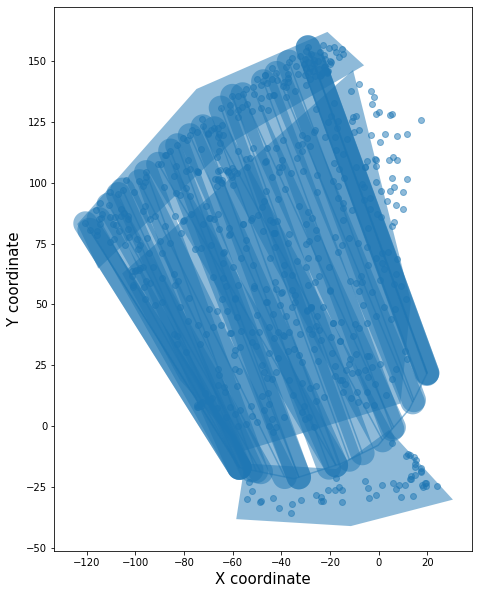

In [ ]:
trees_covered_by_line_set = [set(x) for x in line_gdf["id_trees_covered"]]
covered_set = set_cover.set_cover(set(tree_gpd["id"]),trees_covered_by_line_set)
# find the corresponding lines in the df and filter the df by that, so to leave only those lines
covered_lines_gdf = line_gdf[line_gdf["id_trees_covered"].isin(covered_set)]
# and get their boundings boxes to plot them later
bb_covered_lines_gdf = gpd.GeoDataFrame(geometry=covered_lines_gdf["buffer"])

# and plot it
plotting.plot_gdfs([tree_gpd,extra_geometry_gpd,covered_lines_gdf,bb_covered_lines_gdf])

#### MOO PyOMO Optimization

Using the pymoo library to determine the optimal layout

In [ ]:
# set the index of the line_gdf explicitly to make sure we have our x_j
line_gdf['index_column'] = line_gdf.index

# Generate a numpy array from the line_gdf which can be parsed by PYMOO
columns_array = line_gdf[['line_length', 'slope_deviation','amount_trees_covered', 'buffer_width', 'line_cost',
       'line_active','id_trees_covered',"index_column"]].to_numpy()

##### Computing the Constraints

We have to constrain the problem to enforce that the set of trees is actually covered

In [ ]:
constraint_list = []
highest_tree_id = max(line_gdf["id_trees_covered"].max()).astype(int)

# for each tree id
for id in range(0,highest_tree_id):
    # get the index of this line
    # if the tree id is in the trees covered by this line
    # add the list of line ids that cover this tree id as set to the constraint list
    constraint_list.append({index_column if id in id_trees_covered else None for index_column, id_trees_covered in zip(line_gdf["index_column"],line_gdf["id_trees_covered"])})

In [3]:
import numpy as np
from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.factory import get_sampling, get_crossover, get_mutation
from pymoo.factory import get_termination
from pymoo.optimize import minimize
from pyparsing import line

reload(optimization_functions)

class LineOptimizationProblem(ElementwiseProblem):

#'line_length'      = 0
#'slope_deviation'  = 1
#'amount_trees_covered' = 2, 
#'buffer_width'     = 3, 
#'line_cost'        = 4
#'line_active'      = 5

    def __init__(self):
        super().__init__(n_var=6,
                         n_obj=2,
                         n_constr=0,
                         xl=np.array([0, 0, 0, 0, 0, 0]),  # lower bounds
                         xu=np.array([200, 100, 20, 200, 200, 200]))  # upper bounds

    def _evaluate(self, columns_array, out, *args, **kwargs):
        f1 = optimization_functions.line_cost_function(columns_array[3], columns_array[0], columns_array[1], columns_array[5])
        f2 = optimization_functions.tree_coverage_function(columns_array[2], columns_array[5])

        out["F"] = [f1, f2]
        out["G"] = []


algorithm = NSGA2(
    pop_size=40,
    n_offsprings=10,
    sampling=get_sampling("real_random"),
    crossover=get_crossover("real_sbx", prob=0.9, eta=15),
    mutation=get_mutation("real_pm", eta=20),
    eliminate_duplicates=True
)

problem = LineOptimizationProblem()
termination = get_termination("n_gen", 40)

res = minimize(problem,
               algorithm,
               termination,
               seed=1,
               save_history=True,
               verbose=True)

X = res.X
F = res.F


NameError: name 'reload' is not defined

#### PySAL LSCP

Back to start - framing our problem via PySAL - https://pysal.org/spopt/notebooks/lscp.html

Variables:
L = potential facility sites = potential lines = name/store
D = set of demand points that must be serviced = trees = destination_name
F = subset of L that minimizes distance from D to next facility

In [2]:
# Set up the inner_trees list as gdf
inner_forest_trees_gdf = gpd.GeoDataFrame(geometry=inner_forest_trees)

# Computing the distance from all lines to all points

#create df with nrow = ntrees
distances_df = pd.DataFrame(index=range(0,len(inner_forest_trees_gdf)))

# compute the distance to each tree for every row
# could probably also be done as vectorized operation
for line in line_gdf.iterrows():
    distances = inner_forest_trees_gdf.geometry.distance(line[1].geometry)
    distances_df[line[1]["index_column"]] = distances

NameError: name 'gpd' is not defined

##### MILP Optimization

##### Define Problem, Algorithm and Solve

In [1]:
#pivot the table and convert to numpy matrix (solver expects it this way)
distance_cost_matrix = distances_df.to_numpy()

# sort the facility (=lines) and demand points (=trees)
facility_points_gdf = line_gdf.sort_values(by="index_column").reset_index()
demand_points_gdf = inner_forest_trees_gdf.reset_index()

# ai is demand weight - set to 100 in this case
ai = [100]*len(demand_points_gdf)

NameError: name 'distances_df' is not defined

In [1]:
from spopt.locate.coverage import LSCP

service_radius = 11
solver = pulp.PULP_CBC_CMD(msg=False, warmStart=True)

lscp = LSCP.from_cost_matrix(distance_cost_matrix, service_radius)
lscp = lscp.solve(solver)

NameError: name 'pulp' is not defined

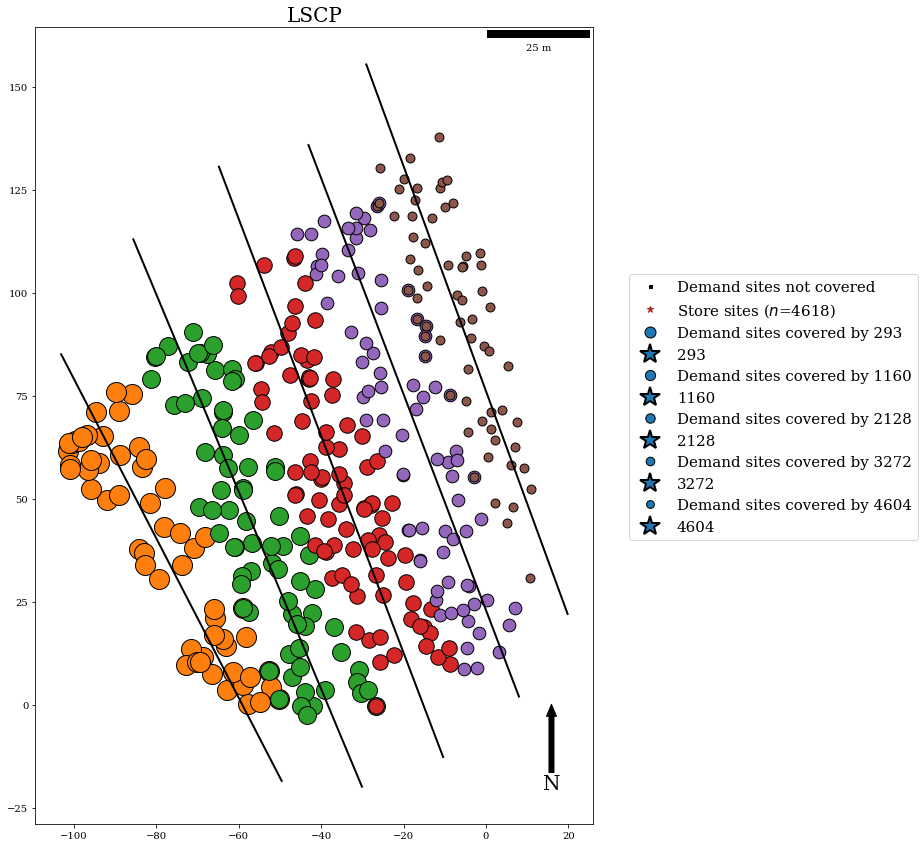

In [ ]:
plotting.plot_lcsp_results(lscp, facility_points_gdf, demand_points_gdf, facility_points_gdf.shape[0], "LSCP", lscp.problem.objective.value())

#### And again with SpOPT/PULP

to steal the spyopts code and extend it

In [ ]:
# fac vars / line variables - create those as binary variable
line_vars = [
    pulp.LpVariable(
        "line".format(i=i), lowBound=0, upBound=1, cat=pulp.LpInteger
    )
    for i in range(len(line_gdf))
]

# Create an index if line1*tree1, line1*tree2 etc are active - shape: (nr_trees,nr_lines)
line_tree_active_index = np.zeros((len(tree_gpd),len(line_gdf)))
line_tree_active_index.shape


#ni - array of candidate sites between fac/lines within distance to supply demand point/tree
# j = line, i = tree var, n[i][j] - i is row, j is column -> ni = [l1,l2,l3,..](for t1),[l1,l2,l3],...
constraint_list = []
for i in range(1,len(tree_gpd)):
    constraint_list.append(pulp.lpSum([line_tree_active_index[i][j] * line_vars[j] for j in range(len(line_gdf))]) >= 1)



In [ ]:
# Copy the from_cost_matrix function

r_fac = range(line_tree_active_index.shape[1])
r_cli = range(line_tree_active_index.shape[0])

name = "LSCP"
model = pulp.LpProblem(name, pulp.LpMinimize)
lscp = LSCP(name, model)

FacilityModelBuilder.add_facility_integer_variable(lscp, r_fac, "x[{i}]")

lscp.aij = np.zeros(cost_matrix.shape)
lscp.aij[cost_matrix <= service_radius] = 1

if predefined_facilities_arr is not None:
    FacilityModelBuilder.add_predefined_facility_constraint(
        lscp, lscp.problem, predefined_facilities_arr
    )

lscp.__add_obj()
FacilityModelBuilder.add_set_covering_constraint(
    lscp, lscp.problem, lscp.aij, r_fac, r_cli
)

return lscp